<a href="https://colab.research.google.com/github/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/blob/main/Tax_Cuts_on_the_Economy_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Impact of Corporate Tax Cuts on Employment, Wages, Investment, and Output

## Setup

In [174]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [175]:
# display all float values in Pandas dataframe to 2 demical places
pd.options.display.float_format = "{:,.2f}".format

Data source: all raw data are downloaded from [Statistics Canada](https://www150.statcan.gc.ca/n1/en/type/data?MM=1) and saved to [this](https://github.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec) GitHub project in the `raw_data` folder.

## Functions
We designed several functions to help reduce the work needed to clean our raw data.

In [176]:
# a function that performs the following tasks to df, a Pandas dataframe with uncleaned data:
# - change the data type of the column year to int
# - fill all missing values based on the most previously available value of the column
# - change the data type of the column num_col to int (if num_decimals == 0) or 
#   float (round to num_decimals if num_decimals > 0)
# - generate dummy variables for province and sector variables;
#   eg: is_quebec = 1 if province == Quebec, 0 otherwise
def clean_data(df, num_col, num_decimals):
  # change the data type of the column year to int
  df['year'] = df['year'].astype(np.float32).astype(int)

  # fill all missing values based on the most previously available value of the column
  df = df.fillna(method='ffill')

  # change the data type of the column num_col to int or float
  df[num_col] = df[num_col].replace({',': ''}, regex=True)
  df[num_col] = df[num_col].astype(np.float32)
  if num_decimals == 0:
    df[num_col] = df[num_col].astype(int)
  else:
    df[num_col] = df[num_col].round(num_decimals)

  # generate dummy variables for province and sector variables
  df['is_quebec'] = (df['province'] == 'Quebec')
  df['is_manu'] = (df['sector'] == 'Manufacturing')
  df = df.astype({'is_quebec': int, 'is_manu': int})

  # generate a variable that joins province and sector together
  df['province_sector'] = df.apply(lambda x: ' & '.join([x['province'], x['sector']]), axis=1)

  return df

## Employment Data

In [177]:
# get raw data URL from github
emp_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/employment.csv'

# load employment data to a dataframe and remove top and bottom meaningless rows
df_emp_monthly = pd.read_csv(emp_url, skiprows=11, skipfooter=18, header=None, engine='python')
df_emp_monthly = df_emp_monthly.rename(columns={0: 'province', 1: 'sector', 2: 'monthyear', 3: 'employment'})

In [178]:
# extract year
df_emp_monthly['year'] = df_emp_monthly['monthyear'].str[-4:]

# clean data
df_emp_monthly = clean_data(df_emp_monthly, 'employment', 0)

df_emp_monthly.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   province         336 non-null    object
 1   sector           336 non-null    object
 2   monthyear        336 non-null    object
 3   employment       336 non-null    int64 
 4   year             336 non-null    int64 
 5   is_quebec        336 non-null    int64 
 6   is_manu          336 non-null    int64 
 7   province_sector  336 non-null    object
dtypes: int64(4), object(4)
memory usage: 21.1+ KB


In [179]:
# aggregate df_emp_monthly by year to get annual employment; 
# aggregate by mean to get an estimate of the acutal annual employment
df_emp = df_emp_monthly.groupby(['year', 'province', 'sector', 
                                 'province_sector', 'is_quebec', 'is_manu']).mean('employment').reset_index()
df_emp['employment'] = df_emp['employment'].astype(int)

df_emp

,year,province,sector,province_sector,is_quebec,is_manu,employment
0,2011,Ontario,Construction,Ontario & Construction,0,0,281774
1,2011,Ontario,Manufacturing,Ontario & Manufacturing,0,1,654746
2,2011,Quebec,Construction,Quebec & Construction,1,0,178295
3,2011,Quebec,Manufacturing,Quebec & Manufacturing,1,1,419194
4,2012,Ontario,Construction,Ontario & Construction,0,0,291414
5,2012,Ontario,Manufacturing,Ontario & Manufacturing,0,1,663483
6,2012,Quebec,Construction,Quebec & Construction,1,0,186857
7,2012,Quebec,Manufacturing,Quebec & Manufacturing,1,1,417350
8,2013,Ontario,Construction,Ontario & Construction,0,0,296760
9,2013,Ontario,Manufacturing,Ontario & Manufacturing,0,1,660570


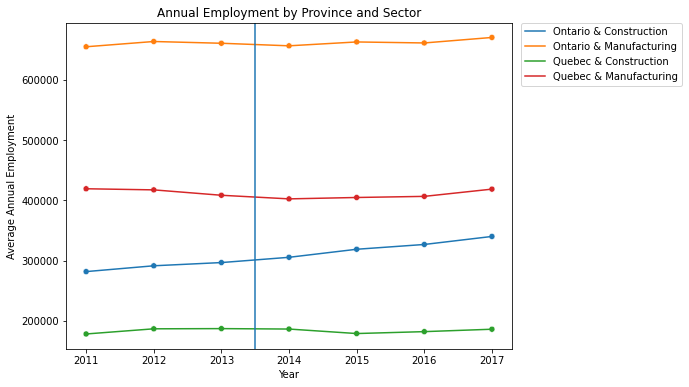

In [180]:
# plot time series trend of annual employment by province_sector
plt.figure(figsize=(8,6))
fig_emp = sns.lineplot(data=df_emp, x='year', y='employment', hue='province_sector')
sns.scatterplot(data=df_emp, x='year', y='employment', hue='province_sector', legend=False)
plt.axvline(2013.5)
fig_emp.legend_.set_title('')
sns.move_legend(fig_emp, "upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
fig_emp.title.set_text('Annual Employment by Province and Sector')
plt.xlabel('Year')
plt.ylabel('Average Annual Employment')
plt.show()

## Wages Data

### Total employees, all wages

#### Full-time worker, all age groups, all genders

In [181]:
# get raw data URL from github
all_wages_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/all_wages.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_all_wages = pd.read_csv(all_wages_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_all_wages = df_all_wages.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'all_wages'})

In [182]:
# clean data
df_all_wages = clean_data(df_all_wages, 'all_wages', 1)

df_all_wages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   province         28 non-null     object 
 1   sector           28 non-null     object 
 2   year             28 non-null     int64  
 3   all_wages        28 non-null     float32
 4   is_quebec        28 non-null     int64  
 5   is_manu          28 non-null     int64  
 6   province_sector  28 non-null     object 
dtypes: float32(1), int64(3), object(3)
memory usage: 1.5+ KB


In [183]:
df_all_wages

,province,sector,year,all_wages,is_quebec,is_manu,province_sector
0,Quebec,Construction,2011,180.40,1,0,Quebec & Construction
1,Quebec,Construction,2012,184.60,1,0,Quebec & Construction
2,Quebec,Construction,2013,192.60,1,0,Quebec & Construction
3,Quebec,Construction,2014,175.20,1,0,Quebec & Construction
4,Quebec,Construction,2015,162.10,1,0,Quebec & Construction
5,Quebec,Construction,2016,164.70,1,0,Quebec & Construction
6,Quebec,Construction,2017,176.00,1,0,Quebec & Construction
7,Quebec,Manufacturing,2011,456.70,1,1,Quebec & Manufacturing
8,Quebec,Manufacturing,2012,459.30,1,1,Quebec & Manufacturing
9,Quebec,Manufacturing,2013,461.10,1,1,Quebec & Manufacturing


#### Full-time worker, all age groups, by gender

### Average hourly wage rate

#### Full-time worker, all age groups, all genders

In [184]:
# get raw data URL from github
hourly_wage_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/hourly_wage.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_hourly_wage = pd.read_csv(hourly_wage_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_hourly_wage = df_hourly_wage.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'hourly_wage'})

In [185]:
# clean data
df_hourly_wage = clean_data(df_hourly_wage, 'hourly_wage', 2)

df_hourly_wage.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   province         28 non-null     object 
 1   sector           28 non-null     object 
 2   year             28 non-null     int64  
 3   hourly_wage      28 non-null     float32
 4   is_quebec        28 non-null     int64  
 5   is_manu          28 non-null     int64  
 6   province_sector  28 non-null     object 
dtypes: float32(1), int64(3), object(3)
memory usage: 1.5+ KB


In [186]:
df_hourly_wage

,province,sector,year,hourly_wage,is_quebec,is_manu,province_sector
0,Quebec,Construction,2011,24.79,1,0,Quebec & Construction
1,Quebec,Construction,2012,25.48,1,0,Quebec & Construction
2,Quebec,Construction,2013,26.24,1,0,Quebec & Construction
3,Quebec,Construction,2014,26.68,1,0,Quebec & Construction
4,Quebec,Construction,2015,27.13,1,0,Quebec & Construction
5,Quebec,Construction,2016,28.32,1,0,Quebec & Construction
6,Quebec,Construction,2017,29.30,1,0,Quebec & Construction
7,Quebec,Manufacturing,2011,21.76,1,1,Quebec & Manufacturing
8,Quebec,Manufacturing,2012,22.65,1,1,Quebec & Manufacturing
9,Quebec,Manufacturing,2013,22.79,1,1,Quebec & Manufacturing


#### Full-time worker, all age groups, by gender

## Investment Data

### Total non-residential capital

In [187]:
# get raw data URL from github
inv_non_res_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_non_res.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_non_res = pd.read_csv(inv_non_res_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_non_res = df_inv_non_res.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [188]:
# clean data
df_inv_non_res = clean_data(df_inv_non_res, 'investment', 0)

df_inv_non_res.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   province         28 non-null     object
 1   sector           28 non-null     object
 2   year             28 non-null     int64 
 3   investment       28 non-null     int64 
 4   is_quebec        28 non-null     int64 
 5   is_manu          28 non-null     int64 
 6   province_sector  28 non-null     object
dtypes: int64(4), object(3)
memory usage: 1.7+ KB


In [189]:
df_inv_non_res

,province,sector,year,investment,is_quebec,is_manu,province_sector
0,Quebec,Construction,2011,1257,1,0,Quebec & Construction
1,Quebec,Construction,2012,1177,1,0,Quebec & Construction
2,Quebec,Construction,2013,1200,1,0,Quebec & Construction
3,Quebec,Construction,2014,861,1,0,Quebec & Construction
4,Quebec,Construction,2015,878,1,0,Quebec & Construction
5,Quebec,Construction,2016,828,1,0,Quebec & Construction
6,Quebec,Construction,2017,1154,1,0,Quebec & Construction
7,Quebec,Manufacturing,2011,6727,1,1,Quebec & Manufacturing
8,Quebec,Manufacturing,2012,6717,1,1,Quebec & Manufacturing
9,Quebec,Manufacturing,2013,6434,1,1,Quebec & Manufacturing


### Machinery and equipment

In [190]:
# get raw data URL from github
inv_me_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_machinery_equipment.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_me = pd.read_csv(inv_me_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_me = df_inv_me.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [191]:
# clean data
df_inv_me = clean_data(df_inv_me, 'investment', 0)

df_inv_me.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   province         28 non-null     object
 1   sector           28 non-null     object
 2   year             28 non-null     int64 
 3   investment       28 non-null     int64 
 4   is_quebec        28 non-null     int64 
 5   is_manu          28 non-null     int64 
 6   province_sector  28 non-null     object
dtypes: int64(4), object(3)
memory usage: 1.7+ KB


In [192]:
df_inv_me

,province,sector,year,investment,is_quebec,is_manu,province_sector
0,Quebec,Construction,2011,1028,1,0,Quebec & Construction
1,Quebec,Construction,2012,967,1,0,Quebec & Construction
2,Quebec,Construction,2013,962,1,0,Quebec & Construction
3,Quebec,Construction,2014,648,1,0,Quebec & Construction
4,Quebec,Construction,2015,670,1,0,Quebec & Construction
5,Quebec,Construction,2016,634,1,0,Quebec & Construction
6,Quebec,Construction,2017,909,1,0,Quebec & Construction
7,Quebec,Manufacturing,2011,2598,1,1,Quebec & Manufacturing
8,Quebec,Manufacturing,2012,2563,1,1,Quebec & Manufacturing
9,Quebec,Manufacturing,2013,2442,1,1,Quebec & Manufacturing


### Intellectual property products

In [193]:
# get raw data URL from github
inv_ip_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_ip.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_ip = pd.read_csv(inv_ip_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_ip = df_inv_ip.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [194]:
# clean data
df_inv_ip = clean_data(df_inv_ip, 'investment', 0)

df_inv_ip.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   province         28 non-null     object
 1   sector           28 non-null     object
 2   year             28 non-null     int64 
 3   investment       28 non-null     int64 
 4   is_quebec        28 non-null     int64 
 5   is_manu          28 non-null     int64 
 6   province_sector  28 non-null     object
dtypes: int64(4), object(3)
memory usage: 1.7+ KB


In [195]:
df_inv_ip

,province,sector,year,investment,is_quebec,is_manu,province_sector
0,Quebec,Construction,2011,52,1,0,Quebec & Construction
1,Quebec,Construction,2012,56,1,0,Quebec & Construction
2,Quebec,Construction,2013,69,1,0,Quebec & Construction
3,Quebec,Construction,2014,66,1,0,Quebec & Construction
4,Quebec,Construction,2015,62,1,0,Quebec & Construction
5,Quebec,Construction,2016,47,1,0,Quebec & Construction
6,Quebec,Construction,2017,56,1,0,Quebec & Construction
7,Quebec,Manufacturing,2011,2650,1,1,Quebec & Manufacturing
8,Quebec,Manufacturing,2012,2643,1,1,Quebec & Manufacturing
9,Quebec,Manufacturing,2013,3010,1,1,Quebec & Manufacturing


## Total Output Data

In [196]:
# get raw data URL from github
output_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/output1.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_output_subsec = pd.read_csv(output_url, skiprows=11, skipfooter=12, header=None, engine='python', on_bad_lines='skip')

# name the headers
df_output_subsec = df_output_subsec.rename(columns={0: 'sector', 1: 'year', 2: 'Ontario', 3: 'Quebec'})

In [197]:
# fill all missing values based on the most previously available value of the column
df_output_subsec = df_output_subsec.fillna(method='ffill')

# unpivot the table to match the format of other tables
df_output_subsec = df_output_subsec.melt(id_vars=['sector', 'year'], var_name='province', value_name='output')

# combine all construction subsectors into an overall construction sector
df_output_subsec['sector'].loc[df_output_subsec['sector'].str.contains('construction')] = 'Construction'
df_output_subsec['sector'].loc[df_output_subsec['sector'].str.contains('Manufacturing')] = 'Manufacturing'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [198]:
# clean data
df_output_subsec = clean_data(df_output_subsec, 'output', 1)

In [199]:
df_output = df_output_subsec.groupby(['year', 'province', 'sector', 
                               'province_sector', 'is_quebec', 'is_manu']).sum('output').reset_index()
df_output['output'] = df_output['output'].round(1)

df_output.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             28 non-null     int64  
 1   province         28 non-null     object 
 2   sector           28 non-null     object 
 3   province_sector  28 non-null     object 
 4   is_quebec        28 non-null     int64  
 5   is_manu          28 non-null     int64  
 6   output           28 non-null     float32
dtypes: float32(1), int64(3), object(3)
memory usage: 1.5+ KB


In [200]:
df_output

,year,province,sector,province_sector,is_quebec,is_manu,output
0,2011,Ontario,Construction,Ontario & Construction,0,0,"50,888.90"
1,2011,Ontario,Manufacturing,Ontario & Manufacturing,0,1,"145,645.09"
2,2011,Quebec,Construction,Quebec & Construction,1,0,"81,076.90"
3,2011,Quebec,Manufacturing,Quebec & Manufacturing,1,1,"289,492.41"
4,2012,Ontario,Construction,Ontario & Construction,0,0,"55,139.20"
5,2012,Ontario,Manufacturing,Ontario & Manufacturing,0,1,"148,294.41"
6,2012,Quebec,Construction,Quebec & Construction,1,0,"85,202.70"
7,2012,Quebec,Manufacturing,Quebec & Manufacturing,1,1,"301,628.50"
8,2013,Ontario,Construction,Ontario & Construction,0,0,"52,597.10"
9,2013,Ontario,Manufacturing,Ontario & Manufacturing,0,1,"146,463.50"
